-  This problem consist of building five houses in different locations; the tasks must be scheduled according to their precedence constraints.

-  There are three workers, and each worker has a given skill level for each task. Each task requires one worker; the worker assigned must have a non-null skill level for the task. A worker can be assigned to only one task at a time.

-  Each house has a deadline.

-  The objective is to maximize the skill levels of the workers assigned to the tasks.

In [40]:
from docplex.cp.model import CpoModel
from sys import stdout
from collections import namedtuple

### Modeling the Data

In [41]:
HOUSES_NUMBER = 5
PERIODS = 318
HOUSE = range(1, HOUSES_NUMBER + 1)

#### All tasks must start and end between 0 and the max amount of periods 


In [42]:
period_domain = (0, PERIODS)

#### Task Durations

In [43]:
Task = (namedtuple("Task", ["name", "duration"]))
TASKS = {Task("masonry",   35),
         Task("carpentry", 15),
         Task("plumbing",  40),
         Task("ceiling",   15),
         Task("roofing",    5),
         Task("painting",  10),
         Task("windows",    5),
         Task("facade",    10),
         Task("garden",     5),
         Task("moving",     5),
        }

In [44]:
Precedence = (namedtuple("Precedence", ["beforeTask", "afterTask"]))
TASK_PRECEDENCES = {Precedence("masonry",   "carpentry"),
                    Precedence("masonry",   "plumbing"),
                    Precedence("masonry",   "ceiling"),
                    Precedence("carpentry", "roofing"),
                    Precedence("ceiling",   "painting"),
                    Precedence("roofing",   "windows"),
                    Precedence("roofing",   "facade"),
                    Precedence("plumbing",  "facade"),
                    Precedence("roofing",   "garden"),
                    Precedence("plumbing",  "garden"),
                    Precedence("windows",   "moving"),
                    Precedence("facade",    "moving"),
                    Precedence("garden",    "moving"),
                    Precedence("painting",  "moving"),
                   }

In [45]:
WORKERS = {"Ali", "Faisal", "Sharif"}

In [46]:
Skill = (namedtuple("Skill", ["worker", "task", "level"]))
SKILLS = {Skill("Ali",  "masonry",   9),
          Skill("Ali",  "carpentry", 7),
          Skill("Ali",  "ceiling",   5),
          Skill("Ali",  "roofing",   6),
          Skill("Ali",  "windows",   8),
          Skill("Ali",  "facade",    5),
          Skill("Ali",  "garden",    5),
          Skill("Ali",  "moving",    6),
          Skill("Faisal", "masonry",   5),
          Skill("Faisal", "plumbing",  7),
          Skill("Faisal", "ceiling",   8),
          Skill("Faisal", "roofing",   7),
          Skill("Faisal", "painting",  9),
          Skill("Faisal", "facade",    5),
          Skill("Faisal", "garden",    5),
          Skill("Sharif",  "carpentry", 5),
          Skill("Sharif",  "painting",  6),
          Skill("Sharif",  "windows",   5),
          Skill("Sharif",  "garden",    9),
          Skill("Sharif",  "moving",    8)
          }

### Utility functions

In [47]:
def find_tasks(name):
    return next(t for t in TASKS if t.name == name)

In [48]:
def find_skills(worker, task):
    return next(s for s in SKILLS if (s.worker == worker) and (s.task == task))

In [49]:
def find_max_level_skill(task):
    st = [s for s in SKILLS if s.task == task]
    return next(sk for sk in st if sk.level == max([s.level for s in st]))

### Creating Model

In [50]:
model = CpoModel(name="HouseBuilding")

#### Creating Varables

In [51]:
tasks = {}   # dict of interval variable for each house and task
for house in HOUSE:
    for task in TASKS:
        tasks[(house, task)] = model.interval_var(start=period_domain,
                                                end=period_domain,
                                                size=task.duration,
                                                name="house {} task {}".format(house, task))

#### Adding precedence constraints

In [52]:
for h in HOUSE:
    for p in TASK_PRECEDENCES:
        model.add(model.end_before_start(tasks[(h, find_tasks(p.beforeTask))], tasks[(h, find_tasks(p.afterTask))]))

In [53]:
wtasks = {}  # dict of interval variable for each house and skill
for house in HOUSE:
    for skill in SKILLS:
        iv = model.interval_var(name='H' + str(house) + '-' + skill.task + '(' + skill.worker + ')')
        iv.set_optional()
        wtasks[(house, skill)] = iv

To constrain the solution so that exactly one of the interval variables wtasks associated with a given task of a given house is to be present in the solution, an "alternative" constraint is used.

In [54]:
for h in HOUSE:
    for t in TASKS:
        model.add(model.alternative(tasks[(h, t)], [wtasks[(h, s)] for s in SKILLS if (s.task == t.name)], 1))

To add the constraints that a given worker can be assigned only one task at a given moment in time, a noOverlap constraint is used.

In [55]:
for w in WORKERS:
    model.add(model.no_overlap([wtasks[(h, s)] for h in HOUSE for s in SKILLS if s.worker == w]))

The objective of this problem is to maximize the skill level used for all the tasks.

In [56]:
obj = model.sum([s.level * model.presence_of(wtasks[(h, s)]) for s in SKILLS for h in HOUSE])
model.add(model.maximize(obj))

Solving the model

In [57]:
# Solve the model
print("\nSolving model....")
msol = model.solve(TimeLimit=10)


Solving model....


In [58]:
print("Solve status: " + msol.get_solve_status())
if msol.is_solution():
    stdout.write("Solve time: " + str(msol.get_solve_time()) + "\n")
    # Sort tasks in increasing begin order
    ltasks = []
    for hs in HOUSE:
        for tsk in TASKS:
            (beg, end, dur) = msol[tasks[(hs, tsk)]]
            ltasks.append((hs, tsk, beg, end, dur))
    ltasks = sorted(ltasks, key = lambda x : x[2])
    # Print solution
    print("\nList of tasks in increasing start order:")
    for tsk in ltasks:
        print("From " + str(tsk[2]) + " to " + str(tsk[3]) + ", " + tsk[1].name + " in house " + str(tsk[0]))
else:
    stdout.write("No solution found\n")

Solve status: Feasible
Solve time: 10.015230655670166

List of tasks in increasing start order:
From 0 to 35, masonry in house 3
From 0 to 35, masonry in house 4
From 35 to 50, ceiling in house 4
From 35 to 70, masonry in house 5
From 50 to 90, plumbing in house 4
From 50 to 60, painting in house 4
From 70 to 105, masonry in house 1
From 90 to 130, plumbing in house 5
From 105 to 140, masonry in house 2
From 130 to 145, ceiling in house 1
From 140 to 155, carpentry in house 2
From 140 to 155, ceiling in house 3
From 145 to 160, ceiling in house 2
From 155 to 165, painting in house 1
From 155 to 170, carpentry in house 1
From 160 to 200, plumbing in house 1
From 165 to 175, painting in house 2
From 170 to 185, carpentry in house 3
From 185 to 200, carpentry in house 4
From 200 to 240, plumbing in house 2
From 200 to 215, ceiling in house 5
From 215 to 225, painting in house 5
From 215 to 230, carpentry in house 5
From 230 to 235, roofing in house 2
From 235 to 240, windows in house 2
Fr

In [59]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

In [62]:
def compact_name(name,n): return name[:n]

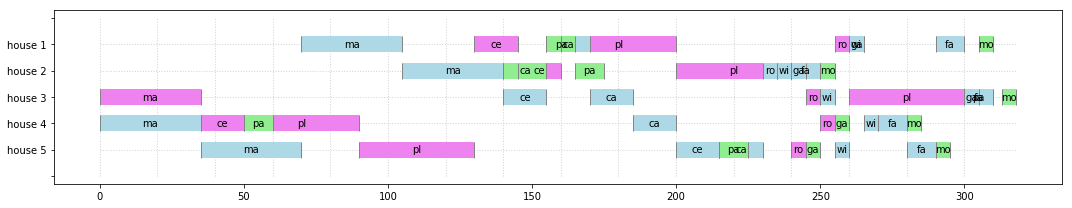

In [64]:
if msol and visu.is_visu_enabled():
    workers_colors = {}
    workers_colors["Ali"] = 'lightblue'
    workers_colors["Faisal"] = 'violet'
    workers_colors["Sharif"] = 'lightgreen'
    visu.timeline('Solution per houses', 0, PERIODS)
    for h in HOUSE:
        visu.sequence(name="house " + str(h))
        for s in SKILLS:
            wt = msol.get_var_solution(wtasks[(h,s)])
            if wt.is_present():
                color = workers_colors[s.worker]
                wtname = compact_name(s.task,2)
                visu.interval(wt, color, wtname)
    visu.show()